# T2D benchmark

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('../../')

In [2]:
import takco
conf = takco.Config('resources/config-dbpedia.toml')
t2dv2 = takco.TableSet.dataset('t2d-v2', **conf)

takco.preview(t2dv2)

In [4]:
%%time
import takco.link

kbs = {k.get("name", k.get("class")): takco.Config(k) for k in conf['kbs']}
# searcher_config = takco.Config({'name': 'dbpedialookup_t2ksubset'}, **kbs)
searcher_config = takco.Config({'name': 'dbpedia_t2ksubset_extralabels'}, **kbs)
searcher_config = takco.Config({
    'name': 'es',
    'class': 'ElasticSearcher',
    'index': 'test-1',
    'baseuri': 'http://dbpedia.org/resource/',
    'es_kwargs': {'hosts': ['bricks07']},
})

pred = takco.TableSet.link(
    takco.DaskHashBag(list(t2dv2)[:20]),
    usecols = "keycol",
    lookup_config = None,
    linker_config = takco.Config({
        "class": "First",
        "limit": 5,
        "search_limit": 5,
        "searcher": searcher_config,
#         "majority_class": "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    }),
)
scored = takco.TableSet.score(pred, labels='t2d-v2', **conf)

report = takco.TableSet.report( scored, keycol_only=True, curve = True )

import pandas as pd
pd.DataFrame.from_dict( report.get('scores'), orient='index' )

CPU times: user 42.7 s, sys: 1.17 s, total: 43.9 s
Wall time: 45.6 s


precision    recall  f1-score  support  predictions
entities   0.222573  0.918642  0.358328     2151         8878

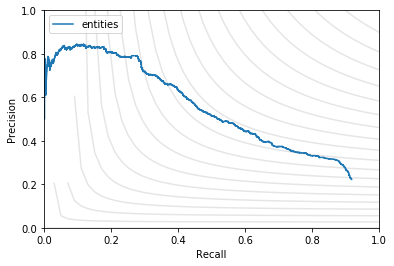

In [5]:
from takco.evaluate import pr_plot
pr_plot(report['curves'])

In [6]:
from takco.link import RDFSearcher, Trident, URIRef

es = searcher_config.init_class(**globals())
g = RDFSearcher(Trident(configuration='kb/dbpedia_t2ksubset/db/'))

missing_gold = []
mistake_gold = []
for table in scored:
    if table.get("gold", {}).get("entities"):
        for ci, ri_ents in table.get("gold", {}).get("entities").items():
            for ri, ents in ri_ents.items():
                for e in ents:
                    if e not in table.get("entities").get(ci, {}).get(ri, {}):
                        if not g.count([URIRef(e), None, None]):
                            missing_gold.append(e)
                        else:
                            mistake_gold.append((e, table.get('tableData')[int(ri)][int(ci)] ))
                            
print('missing:', len(missing_gold), missing_gold[:50])
print()
print('mistake:', len(mistake_gold))
for e, c in mistake_gold[:100]:
    print(e,c)
#     rs = search.search_entities(c.get('text', ''), limit=50, add_about=True)
#     if e in [r.uri for r in rs]:
#         print(e, c, es.labels(e), rs[:1])

missing: 42 ['http://dbpedia.org/resource/The_Exorcist', 'http://dbpedia.org/resource/The_Sun_Also_Rises', "http://dbpedia.org/resource/Earth's_Children", 'http://dbpedia.org/resource/I_Know_Why_the_Caged_Bird_Sings', 'http://dbpedia.org/resource/Single-sex_education', "http://dbpedia.org/resource/Women_on_Top:_How_Real_Life_Has_Changed_Women's_Sexual_Fantasies", 'http://dbpedia.org/resource/Captain_Underpants', 'http://dbpedia.org/resource/On_My_Honor', 'http://dbpedia.org/resource/Arizona_Kid', 'http://dbpedia.org/resource/Punjab_Kesari', 'http://dbpedia.org/resource/BBC_World_Service', 'http://dbpedia.org/resource/Media_of_Sierra_Leone', 'http://dbpedia.org/resource/Hyperion_Tower', 'http://dbpedia.org/resource/Chongqing_World_Trade_Center', 'http://dbpedia.org/resource/Brookfield_Place', 'http://dbpedia.org/resource/Osaka_Prefectural_Government_Sakishima_Building', 'http://dbpedia.org/resource/Chongqing_World_Trade_Center', 'http://dbpedia.org/resource/Imperial_City,_Beijing', 'htt

In [7]:
from rdflib import RDF, RDFS, URIRef
from takco.link import *
search = takco.Config(searcher_config).init_class(**globals())
search.exact = False

txt = "aruba"

results = search.search_entities(txt, limit=50, add_about=True)

print(len(results))
for i, sr in enumerate(results):
    types = sr.get(RDF.type) or []
    if URIRef('http://dbpedia.org/ontology/Book') in types or ('novel' in sr.uri) or True:
        print(i, sr.uri, sr.score, types, [str(l) for p,ls in sr.items() if 'label' in str(p) for l in ls])

50
0 http://dbpedia.org/resource/Aruba_national_football_team 13.297862 [] ['aruba']
1 http://dbpedia.org/resource/Queen_Beatrix_International_Airport 13.261633 [] ['aruba']
2 http://dbpedia.org/resource/Aruba_Football_Federation 13.085565 [] ['aruba']
3 http://dbpedia.org/resource/Miss_Aruba 13.053482 [] ['aruba']
4 http://dbpedia.org/resource/Aruba_(film) 12.980381 [] ['aruba']
5 http://dbpedia.org/resource/Elections_in_Aruba 12.980381 [] ['aruba']
6 http://dbpedia.org/resource/Aruba_Networks 12.943021 [] ['aruba']
7 http://dbpedia.org/resource/Football_in_Aruba 12.943021 [] ['aruba']
8 http://dbpedia.org/resource/Aruba_(film) 12.559998 [] ['aruba ']
9 http://dbpedia.org/resource/Aruba 12.559998 [] ['aruba']
10 http://dbpedia.org/resource/Oranjestad,_Aruba 9.75418 [] ['oranjestad, aruba']
11 http://dbpedia.org/resource/Aruba_national_football_team 9.7072935 [] ['aruba, aruba']
12 http://dbpedia.org/resource/Aruba_Networks 9.684587 [] ['aruba networks']
13 http://dbpedia.org/resource/

In [8]:
takco.preview( scored, nrows=None, hide_correct_rows=True )

In [10]:
!time takco run -v -C resources/config-dbpedia.toml resources/pipelines/t2d-v2-baseline.toml

INFO:root:Set log level to 20
INFO:root:Loaded config {'name': 'config-dbpedia', 'datadir': 'data', 'resourcedir': 'resources', 'cache': False, 'kbs': [{'name': 'dbpedia_t2ksubset', 'class': 'RDFSearcher', 'labelProperties': ['http://dbpedia.org/ontology/title'], 'store': {'class': 'Trident', 'configuration': 'kb/dbpedia_t2ksubset/db/'}}, {'name': 'dbpedia_2014_part2', 'class': 'RDFSearcher', 'labelProperties': ['http://dbpedia.org/ontology/title'], 'store': {'class': 'Trident', 'configuration': 'kb/dbpedia/2014_part2/'}}, {'name': 'dbpedia_2016', 'class': 'RDFSearcher', 'labelProperties': ['http://dbpedia.org/ontology/title'], 'store': {'class': 'Trident', 'configuration': 'kb/dbpedia/2016-10/'}}, {'name': 'dbpedialookup', 'class': 'DBpediaLookup'}], 'assets': [{'name': 't2d-v1', 'class': 'T2D', 'download': ['http://webdatacommons.org/webtables/tables_instance.tar.gz', 'http://webdatacommons.org/webtables/entities_instance.tar.gz', 'http://webdatacommons.org/webtables/classes_instance